In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import os
import shutil
from tqdm.auto import tqdm
import imageio
import einops
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torchvision.utils import save_image

device = torch.device("cuda:0")

from UNetSmall import *
from DDPM_gen_vis import *
from CustomizableCosineDecayScheduler import CosineDecayWithWarmUpScheduler as CD_scheduler

In [2]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
batch_size = 64

dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [3]:
def training_loop(ddpm, loader, n_epochs, optim, device, scheduler=None,
                  display=False, store_path="ddpm_model_FMNIST.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        print(f'Epoch {epoch+1}/{n_epochs}')
        
        epoch_loss = 0.0
           
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
        
        if scheduler is not None:
            scheduler.step()
        
        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Average loss: {epoch_loss:.4f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)
        print('-' * 75)

In [4]:
try:
    del ddpm
except: pass

n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02
ddpm = MyDDPM(UNetSmall(), n_steps=n_steps, 
              min_beta=min_beta, max_beta=max_beta, device=device)

optimizer = optim.Adam(ddpm.parameters(), betas=(0.7, 0.95),
                       lr=3e-4)

scheduler = CD_scheduler(optimizer, 
                    max_lr=3e-4, min_lr=1e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)
ddpm.train()
training_loop(ddpm, loader, n_epochs=60, optim=optimizer, device=device,
             scheduler=scheduler)

Training progress:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60


Epoch 1/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.1525 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 2/60


Epoch 2/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0685 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 3/60


Epoch 3/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0616 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 4/60


Epoch 4/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0571 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 5/60


Epoch 5/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0544 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 6/60


Epoch 6/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0529 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 7/60


Epoch 7/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0520 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 8/60


Epoch 8/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0510 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 9/60


Epoch 9/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0499 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 10/60


Epoch 10/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0484 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 11/60


Epoch 11/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0484
---------------------------------------------------------------------------
Epoch 12/60


Epoch 12/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0473 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 13/60


Epoch 13/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0470 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 14/60


Epoch 14/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0467 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 15/60


Epoch 15/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0455 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 16/60


Epoch 16/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0454 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 17/60


Epoch 17/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0461
---------------------------------------------------------------------------
Epoch 18/60


Epoch 18/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0452 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 19/60


Epoch 19/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0455
---------------------------------------------------------------------------
Epoch 20/60


Epoch 20/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0451 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 21/60


Epoch 21/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0452
---------------------------------------------------------------------------
Epoch 22/60


Epoch 22/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0471
---------------------------------------------------------------------------
Epoch 23/60


Epoch 23/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0465
---------------------------------------------------------------------------
Epoch 24/60


Epoch 24/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0467
---------------------------------------------------------------------------
Epoch 25/60


Epoch 25/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0458
---------------------------------------------------------------------------
Epoch 26/60


Epoch 26/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0460
---------------------------------------------------------------------------
Epoch 27/60


Epoch 27/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0452
---------------------------------------------------------------------------
Epoch 28/60


Epoch 28/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0455
---------------------------------------------------------------------------
Epoch 29/60


Epoch 29/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0451
---------------------------------------------------------------------------
Epoch 30/60


Epoch 30/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0449 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 31/60


Epoch 31/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0446 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 32/60


Epoch 32/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0441 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 33/60


Epoch 33/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0441 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 34/60


Epoch 34/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0438 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 35/60


Epoch 35/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0431 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 36/60


Epoch 36/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0435
---------------------------------------------------------------------------
Epoch 37/60


Epoch 37/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0431
---------------------------------------------------------------------------
Epoch 38/60


Epoch 38/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0438
---------------------------------------------------------------------------
Epoch 39/60


Epoch 39/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0436
---------------------------------------------------------------------------
Epoch 40/60


Epoch 40/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0435
---------------------------------------------------------------------------
Epoch 41/60


Epoch 41/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0430 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 42/60


Epoch 42/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0439
---------------------------------------------------------------------------
Epoch 43/60


Epoch 43/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0444
---------------------------------------------------------------------------
Epoch 44/60


Epoch 44/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0432
---------------------------------------------------------------------------
Epoch 45/60


Epoch 45/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0439
---------------------------------------------------------------------------
Epoch 46/60


Epoch 46/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0435
---------------------------------------------------------------------------
Epoch 47/60


Epoch 47/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0432
---------------------------------------------------------------------------
Epoch 48/60


Epoch 48/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0439
---------------------------------------------------------------------------
Epoch 49/60


Epoch 49/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0433
---------------------------------------------------------------------------
Epoch 50/60


Epoch 50/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0435
---------------------------------------------------------------------------
Epoch 51/60


Epoch 51/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0433
---------------------------------------------------------------------------
Epoch 52/60


Epoch 52/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0435
---------------------------------------------------------------------------
Epoch 53/60


Epoch 53/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0427 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 54/60


Epoch 54/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0428
---------------------------------------------------------------------------
Epoch 55/60


Epoch 55/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0426 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 56/60


Epoch 56/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0429
---------------------------------------------------------------------------
Epoch 57/60


Epoch 57/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0423 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 58/60


Epoch 58/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0427
---------------------------------------------------------------------------
Epoch 59/60


Epoch 59/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0419 --> Best model ever (stored)
---------------------------------------------------------------------------
Epoch 60/60


Epoch 60/60:   0%|          | 0/938 [00:00<?, ?it/s]

Average loss: 0.0413 --> Best model ever (stored)
---------------------------------------------------------------------------


In [4]:
store_path="ddpm_model_FMNIST.pt"
best_model = MyDDPM(UNetSmall(), n_steps=1000, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [5]:
torch.save(best_model.network.state_dict(), "UNet_Small_FMNIST.pt")

In [6]:
torch.cuda.empty_cache()
best_unet_small = UNetSmall()
best_unet_small.load_state_dict(torch.load("UNet_Small_FMNIST.pt", map_location=device))

best_unet_small.eval()
print("Model loaded")

Model loaded


Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

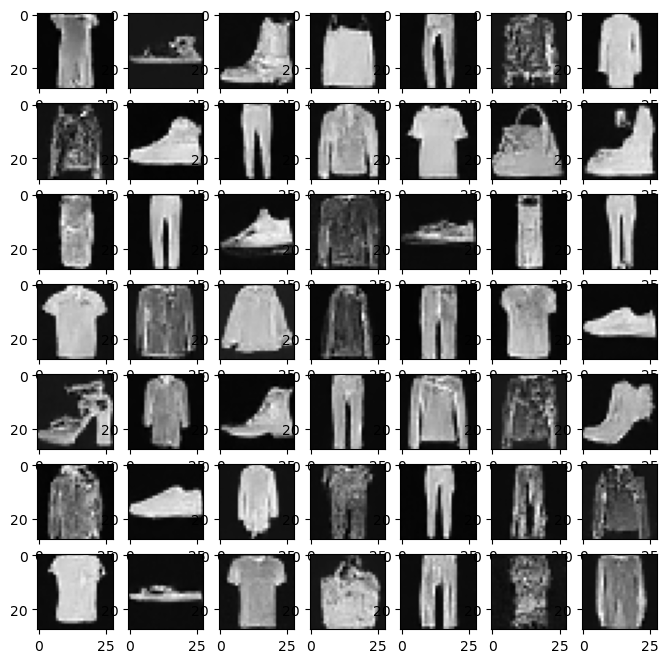

In [8]:
# check if generating works
generated = generate_new_images(
        best_unet_small,
        n_samples=49,
        device=device,
        gif_name="Fmnist.gif",
        n_steps=1000,
        gif=False,
        from_unet=True
    )
show_images(generated, None)

#### Generate samples with different T

In [9]:
# real samples
os.makedirs(f"datasets/FashionMNIST_png", exist_ok=True)
j = 0
for batch in tqdm(loader, desc=f"Progress", colour="#00dd00"):
    for i in range(len(batch[0])):
        save_image(torch.cat([batch[0][i],batch[0][i],batch[0][i]]), f"datasets/FashionMNIST_png/img{j+i}.png")
    
    j += i

Progress:   0%|          | 0/938 [00:00<?, ?it/s]

In [17]:
# fake samples

os.makedirs(f"generated_ddpm_FMNIST", exist_ok=True)

num_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 
             400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

for n in tqdm(num_steps, desc=f"Generating progress", colour="#00dd00"):
    
    torch.cuda.empty_cache()
    
    with torch.no_grad():

        generated = generate_new_images(
                best_unet_small,
                n_samples=5000,
                device=device,
                n_steps=n,
                from_unet=True
            )

    os.makedirs(f"generated_ddpm_FMNIST/{n}", exist_ok=True)
    
    for i in range(len(generated)):
        save_image(torch.cat([generated[i],generated[i],generated[i]]), f"generated_ddpm_FMNIST/{n}/img{i}.png")

In [10]:
# extract features and calculate FID
from FID import extract_real_features, FID_score

# real_features = extract_real_features(path_real, num_features=100)

# with open('real_features.npy', "wb") as f:
#     np.save(f, real_features)
# torch.cuda.empty_cache()

with open("real_features.npy", 'rb') as f:
    real_features = np.load(f)

In [11]:
path_real = "real_features.npy"
num_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 
             400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

scores = []

for n in tqdm(num_steps, leave=False, desc=f"Progress", colour="#009900"):
    torch.cuda.empty_cache()
    path_fake = f"generated_ddpm_FMNIST/{n}/"
    scores.append(FID_score(path_real, path_fake, True))

Progress:   0%|          | 0/28 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
with open('FID_scores_FMNIST_ddpm.npy', "wb") as f:
    np.save(f, np.array(scores))

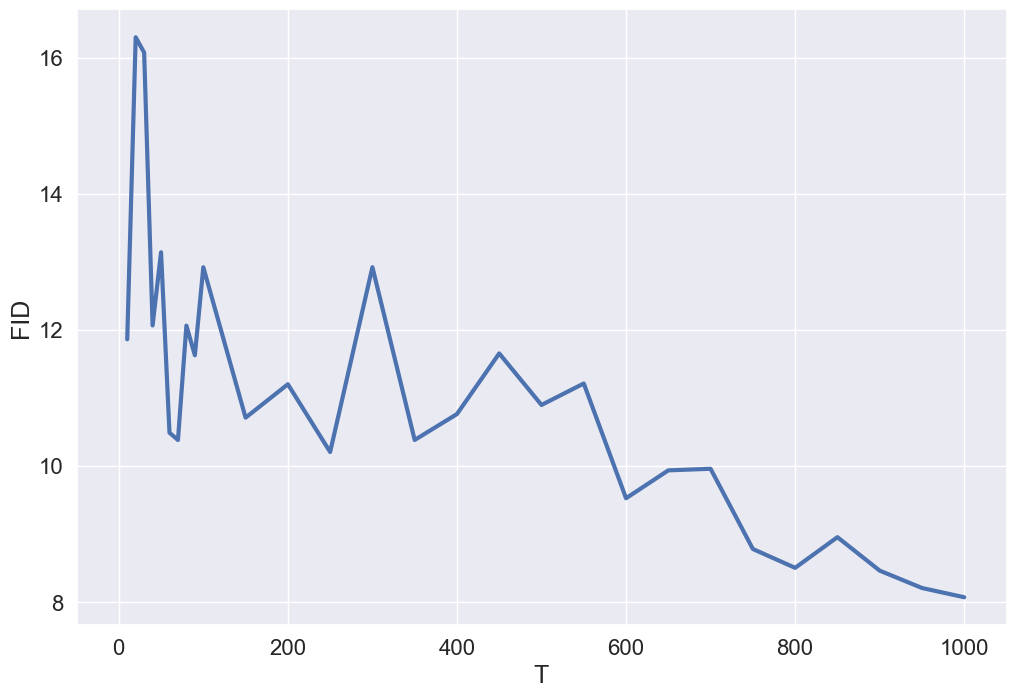

In [22]:
import seaborn as sns
sns.set_theme(style='darkgrid')

plt.figure(figsize=(12,8))

plt.plot(num_steps, scores, lw=3)

plt.xlabel("T", fontsize=18)
plt.ylabel("FID", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=-50, right=1050)

plt.savefig("DDPM_FID_FMNIST.png", bbox_inches='tight')
plt.show()